Load imports

In [1]:
import pandas as pd
import numpy as np
from models.gan import GAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime

Load dataset

In [2]:
df_pokemon= pd.read_csv("data/pokemon_train_set.csv")
df_pokemon.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Evolution
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,Basic
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,Stage1
2,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,Stage2
3,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,Mega
4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,Basic


Preprocessing

In [3]:
df_pokemon = df_pokemon.drop(columns=['Name'], axis=1)
numerical_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
scaler = StandardScaler()
df_pokemon[numerical_cols] = scaler.fit_transform(df_pokemon[numerical_cols])

df_pokemon['Type 2'] = df_pokemon['Type 2'].fillna('None')
df_pokemon = pd.get_dummies(df_pokemon, columns=['Type 1', 'Type 2', 'Generation', 'Evolution'])

bool_cols = df_pokemon.select_dtypes(include=['bool']).columns
df_pokemon[bool_cols] = df_pokemon[bool_cols].astype(int)
column_names = df_pokemon.columns
df_pokemon.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_)Normal,Type 1_Bug,Type 1_Dark,...,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6,Evolution_Basic,Evolution_Mega,Evolution_Stage1,Evolution_Stage2
0,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


Train GAN model

In [4]:
noise = np.random.normal(0, 1, df_pokemon.shape) 
gan = GAN(data=df_pokemon, noise_dim=100, epochs=1000, batch_size=32)
generator = gan.create_generator()
discriminator = gan.create_discriminator()
gan_model = gan.model_compile(generator=generator, discriminator=discriminator)
trained_generator, d_losses, g_losses = gan.train(generator, discriminator, gan_model)

c:\Users\l.huber2\Documents\FH\2. Semester\GAI\Pokemon\venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\l.huber2\Documents\FH\2. Semester\GAI\Pokemon\venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
>1, d_loss=0.693, g_loss=0.692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>2, d_loss=0.692, g_loss=0.688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>3, d_loss=0.691, g_loss=0.682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>4, d_loss=0.690, g_loss=0.675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>5, d_loss=0.689, g_loss=0.665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>6, d_loss=0.688, g_loss=0.656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>7, d_loss=0.687, g_loss=0.643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>8, d_loss=0.686, g_loss=0.629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>9, d_loss=0.687, g_loss=0.614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>10, d_loss=0.688, g_loss=0.599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>11, d_loss=0.689, g_loss=0.585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>12, d_loss=0.694, g_loss=0.569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>13, d_loss=0.701, g_loss=0.556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>14, d_loss=0.708, g_loss=0.544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Get predicitions of GAN model

In [5]:
generate_num = 200
noise = np.random.normal(0, 1, (generate_num, 100))
predicted_data = trained_generator.predict(noise)
predicted_df = pd.DataFrame(predicted_data, columns=column_names)
predicted_df.head(10)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_)Normal,Type 1_Bug,Type 1_Dark,...,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6,Evolution_Basic,Evolution_Mega,Evolution_Stage1,Evolution_Stage2
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.980190,-0.998602,0.986825,-0.999994,...,0.999889,1.000000,0.999952,0.999074,0.999895,1.000000,0.999935,-0.531180,0.999976,0.999889
1,1.000000,1.000000,1.000000,1.000000,1.000000,0.999991,-0.628989,0.998859,0.999800,0.999988,...,0.999877,-0.958218,0.995628,0.999843,0.999797,-0.050077,0.999248,0.999834,0.999668,0.999871
2,0.997312,0.988486,0.998109,-0.680680,0.983446,-0.997003,0.782605,0.862715,0.999500,0.998564,...,0.999671,0.968419,0.964626,0.999910,0.999590,0.989390,0.999789,0.999837,0.999614,0.999922
3,1.000000,1.000000,1.000000,0.999945,1.000000,0.632500,0.999998,-0.922187,0.999881,0.885345,...,0.994161,0.999802,-0.954997,0.999034,0.999489,-0.918079,0.999987,0.998484,0.999911,0.999776
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.999832,1.000000,...,0.996116,-1.000000,0.999998,0.999986,0.999936,0.998319,0.751501,0.999989,0.999937,0.999971
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.997356,0.995289,0.999746,0.999989,...,0.999770,-0.982485,0.143749,0.998502,0.999907,-0.999605,0.999977,0.997420,0.999950,0.999230
6,1.000000,1.000000,1.000000,0.999962,1.000000,0.995740,-0.232125,0.994161,0.999651,0.999953,...,0.999764,-0.516406,0.992747,0.999873,0.999780,0.302628,0.999303,0.999814,0.999779,0.999907
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.999983,1.000000,...,0.999906,-1.000000,1.000000,0.999252,0.999946,-0.903453,-0.946861,0.999942,0.999932,0.999796
8,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.976096,-0.958051,0.998959,-0.882721,...,0.999666,0.999995,0.998099,0.999742,0.999877,0.999988,0.999940,0.928326,0.999860,0.999935
9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.999985,1.000000,0.999684,1.000000,...,0.998839,-1.000000,0.999686,0.998803,0.999301,-0.428176,0.889235,0.999635,0.999534,0.999512


Transform prediction to human readable output

In [6]:
def make_binary_attributes_readable(attributes:list) -> pd.DataFrame:
    for attribute in attributes:
        columns = [col for col in predicted_df.columns if attribute in col]

        # Get the column with the highest value for each row among 'Type 1' columns
        max = predicted_df[columns].idxmax(axis=1)

        # Extract the type name from the column names (removing the 'Type 1_' prefix)
        predicted_df[attribute[:-1]] = max.str.replace(attribute, '')

        # Optionally, you can drop the old type columns if they are no longer needed
        predicted_df.drop(columns=columns, inplace=True)
        predicted_df.head()
    return predicted_df

In [7]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
make_readble_cols= ["Generation_", "Type 1_", "Type 2_","Evolution_"]
readable_df = make_binary_attributes_readable(make_readble_cols) 
readable_df['Legendary'] = readable_df['Legendary'] > 0.75
readable_df[numerical_cols] = scaler.inverse_transform(readable_df[numerical_cols])
readable_df = readable_df.round(0)
readable_df['Total'] = readable_df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].sum(axis=1)
pd.DataFrame.to_csv(readable_df, path_or_buf=f'models/evaluation/data/GAN_generated_data{timestamp}.csv')
readable_df.head(10)

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Generation,Type 1,Type 2,Evolution,Total
0,44.0,47.0,43.0,40.0,44.0,39.0,True,2,Ghost,Dark,Stage1,257.0
1,95.0,111.0,105.0,106.0,100.0,97.0,False,1,Water,Fairy,Stage2,614.0
2,95.0,111.0,105.0,51.0,99.0,39.0,True,4,Normal,Poison,Stage2,500.0
3,95.0,111.0,105.0,106.0,100.0,87.0,True,2,Fighting,Electric,Basic,604.0
4,95.0,111.0,105.0,106.0,100.0,97.0,False,3,)Normal,Bug,Mega,614.0
5,95.0,111.0,105.0,106.0,100.0,97.0,True,5,Fighting,Electric,Basic,614.0
6,95.0,111.0,105.0,106.0,100.0,97.0,False,4,Water,Fairy,Stage2,614.0
7,95.0,111.0,105.0,106.0,100.0,97.0,False,3,)Normal,Bug,Mega,614.0
8,44.0,47.0,43.0,40.0,44.0,39.0,True,2,Ghost,Dark,Basic,257.0
9,95.0,111.0,105.0,106.0,100.0,97.0,False,3,)Normal,Fairy,Mega,614.0


Evaluate GAN

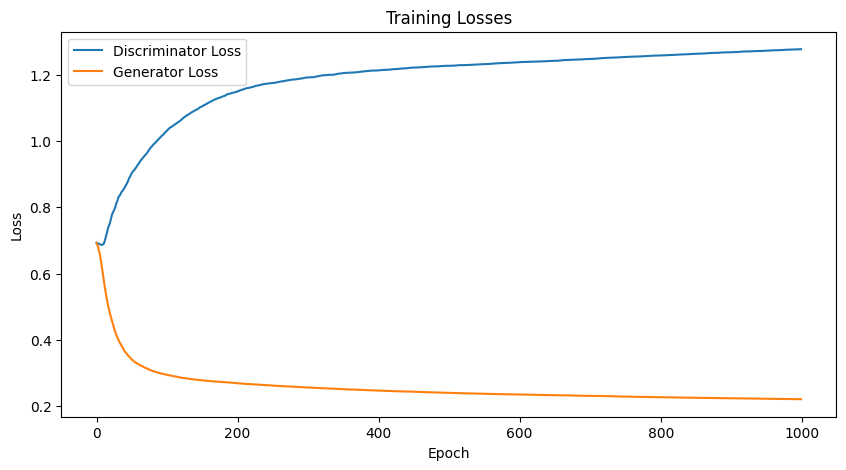

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'models/evaluation/plots/GAN_Training_Losses{timestamp}.png')
plt.show()

In [9]:
print(g_losses)

[array(0.6923238, dtype=float32), array(0.687985, dtype=float32), array(0.68238145, dtype=float32), array(0.6745026, dtype=float32), array(0.6654662, dtype=float32), array(0.6556947, dtype=float32), array(0.6431923, dtype=float32), array(0.6289872, dtype=float32), array(0.6142966, dtype=float32), array(0.5991972, dtype=float32), array(0.5847844, dtype=float32), array(0.5694849, dtype=float32), array(0.55559725, dtype=float32), array(0.5439157, dtype=float32), array(0.5300606, dtype=float32), array(0.5191324, dtype=float32), array(0.5080117, dtype=float32), array(0.49780533, dtype=float32), array(0.48847094, dtype=float32), array(0.47965646, dtype=float32), array(0.47205403, dtype=float32), array(0.4641414, dtype=float32), array(0.45608094, dtype=float32), array(0.44909617, dtype=float32), array(0.44168374, dtype=float32), array(0.43453342, dtype=float32), array(0.42712787, dtype=float32), array(0.42126518, dtype=float32), array(0.41546685, dtype=float32), array(0.41047916, dtype=float3

In [10]:
readable_df.to_csv("TF_Pokemon.csv", index=False, encoding="UTF-8")